### Imports

In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#importing necessary libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [ ]:
#importing necessary libraries
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score,make_scorer
from sklearn.svm import SVC

In [ ]:
#importing necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV

In [ ]:
#importing necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

### Loading and sorting data

In [ ]:
df1 = pd.read_csv('https://www.ee.iitb.ac.in/~asethi/Dump/MouseTrain.csv') #getting the training dataset from the provided link and storing as a pandas dataframe

In [ ]:
df1.head() #looking at the first 5 datapoints to get an idea of ranges

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment_Behavior
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine_C/S
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine_C/S
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine_C/S
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine_C/S
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,NaN,0.104784,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine_C/S


In [ ]:
df2 = pd.read_csv('https://www.ee.iitb.ac.in/~asethi/Dump/MouseTest.csv') #getting the test dataset from the provided link and storing as a pandas dataframe

In [ ]:
X = df1.iloc[:,0:77] #storing the predictor columns in training dataset
Y1 = df1.iloc[:,77] #storing the first target variable in training dataset
Y2 = df1.iloc[:,78] #storing the second target variable in training dataset
N=len(df1) #storing the length of training dataset

In [ ]:
Xtest = df2.iloc[:,0:77] #storing the predictor columns in test dataset
Y1test = df2.iloc[:,77] #storing the first target variable in test dataset
Y2test = df2.iloc[:,78] #storing the second target variable in test dataset

### Data Preprocessing

We should convert names from strings to integers, to facilite usage of scoring metrics.

In [ ]:
lab1 = LabelEncoder() #creating a variable for label encoder
Y1t = lab1.fit_transform(Y1) #using fit_transform method to return encoded labels of binary train target variable
Y1test = lab1.transform(Y1test) #using transform on test target so same mapping as train target is achieved

lab2 = LabelEncoder() #creating a variable for label encoder                    
Y2t = lab2.fit_transform(Y2) #using fit_transform method to return encoded labels of binary train target variable
Y2test = lab2.transform(Y2test) #using transform on test target so same mapping as train target is achieved                      

In [ ]:
# Helper function 
def filtr(series,threshold, greater=True): #defining a function return a series where data is filtered by a threshold
    if greater:                            #if the paramter greater is not changed to false explicitly if clause is run
        return series[series >= threshold] #returns all datapoints in series which are greater than the defined threshold
    else:                                  #if the paramter greater is changed to false else clause is run
        return series[series <= threshold] #returns all datapoints in series which are greater than the defined threshold

Missing Values:

In [ ]:
st1 = (df1.isna().sum()/N) #storing the fraction of data missing in each column in train dataset as a series
miss=filtr(st1,1e-10) #storing values of st1 which are greater than 1e-10
miss #series of columns havingmore than 1e-10 fraction of data missing

ELK_N         0.019685
MEK_N         0.005249
Bcatenin_N    0.019685
BAD_N         0.236220
BCL2_N        0.255906
pCFOS_N       0.078740
H3AcK18_N     0.196850
EGR1_N        0.236220
H3MeK4_N      0.236220
dtype: float64

In [ ]:
st2 = (df2.isna().sum()/len(df2)) #storing the fraction of data missing in each column in test dataset as a series
miss2=filtr(st2,1e-10) #storing values of st1 which are greater than 1e-10
miss2 #series of columns having more than 1e-10 fraction of data missing

BAD_N        0.146667
BCL2_N       0.200000
H3AcK18_N    0.133333
EGR1_N       0.066667
H3MeK4_N     0.400000
dtype: float64

Imputing missing values:

In [ ]:
imp = IterativeImputer(max_iter = 40,random_state=1) #creating a variable for iterative imputer
X_imp = pd.DataFrame(imp.fit_transform(X),columns=X.columns, index = range(len(X))) #storing the imputed train dataset
Xt_imp = pd.DataFrame(imp.transform(Xtest),columns=Xtest.columns, index = range(len(Xtest))) #storing the imputed test dataset
# We are directly storing transformed data in a dataframe

Before normalising data , we should remove features with very low variance i.e which are almost constant.

Checking for low variance/constant columns:

In [ ]:
var_df = X.dropna(axis=1) #Removing NaN values before scaling
var_df= (X - X.min())/(X.max()-X.min()) #making all features on the same scale so that variance is comparable
low_var = filtr(np.var(var_df),0.01,greater=False) #Filtering out the attributes where variance is less than 1% of the range
# The attributes can be considered as more-or-less constant and hence wont affect the classification much
low_var

pELK_N     0.008059
JNK_N      0.009759
RRP1_N     0.004518
GluR4_N    0.005022
dtype: float64

Data Normalisation:

In [ ]:
X.isna().any()

DYRK1A_N     False
ITSN1_N      False
BDNF_N       False
NR1_N        False
NR2A_N       False
             ...  
SYP_N        False
H3AcK18_N     True
EGR1_N        True
H3MeK4_N      True
CaNA_N       False
Length: 77, dtype: bool

In [ ]:
X_test = (Xt_imp - np.mean(X_imp))/X_imp.std() #Normalising Xtest
X = (X_imp - np.mean(X_imp))/X_imp.std() # Normalising X

Checking for highly correlated columns:

In [ ]:
corr_df = X.corr() # to obtain correlation matrix

In [ ]:

remove= []
dct = {}
for i in range(len(corr_df)):
    for j in range(i+1,len(corr_df)): # Since matrix is symmetric, we can iterate only through the elements that are below the diagonal, instead of the full matrix
        cr =abs(corr_df.iloc[i,j]) # finding modlus of the correlation coefficient
        if cr>= 0.9: # Checking if it is above a certain threshold (0.9 in this case)
            col1, col2  = corr_df.index[i], corr_df.columns[j]
            print(col1, col2, cr) # printing out the correlated variables and their correlation coefficient
            remove.append(col2) 
            

DYRK1A_N ITSN1_N 0.9613212072854798
DYRK1A_N pERK_N 0.9472433791411033
DYRK1A_N BRAF_N 0.9655764713541677
ITSN1_N pERK_N 0.9074804338072053
ITSN1_N BRAF_N 0.9286107182545233
NR1_N pNR1_N 0.9468858168031956
NR1_N Bcatenin_N 0.9284625195892839
pERK_N BRAF_N 0.9317428632031813
pNR1_N pNR2B_N 0.900175043525369
ARC_N pS6_N 1.0


In [ ]:
remove = list(set(remove)) #removing one out of each pair of correlated columns
# we remove in such a way that fewer columns remain in data

In [ ]:
np.bincount(Y1t)# Number of instances of class 0 and 1 respectively

array([435, 327])

The Genotype classes are slighly imbalanced.

In [ ]:
np.bincount(Y2t) # Number of instances of class 0,1,2,3 respectively

array([225, 225, 180, 132])

Treatment behaviour has 3 fairly balanced classes, but one class which is much less than others.Hence we should consider it imbalanced

### Feature selection

First we will consider the model by removing all the low variance columns, and some columns which are highly correlated with others.

If there is scope for improvement in testing accuracy, then we will consider other feature combinations like dropping missing values etc..


In [ ]:
C1 = np.concatenate([remove,low_var.index]) #Grouping all the column names that have to be removed

X1t = X.drop(C1,axis=1) #Creating new datframe by removing unwanted columns
X1test = X_test.drop(C1,axis=1) #Test dataframe after removing columns


In [ ]:
X1,X1val,Y1,Y1val=train_test_split(X1t,Y1t,test_size=100,random_state=0)
X1,X1val,Y2,Y2val=train_test_split(X1t,Y2t,test_size=100,random_state=0)
#We keep 100 points for validation, and use the rest as training data
# Setting random_state = 0 ensures that the train data points for both classification tasks is the same

### Metrics

Since both classes are equally important (to our knowledge), precision and recally should have equal weightage, hence we can use F1-score.

For genome classification, we can use F1-score with 'micro' average, since the classes are imbalanced. Micro aveerage gives equal weightage to all datapoints.
We can also use roc_auc_score, since it is a binary classification problem.

For treatment behaviour, it is multiclass classification, we cannot use roc auc score, but we can still use F1-score

### SVM RBF

In [ ]:
gamlist=[1e-3,1e-2,0.1,1,3,5,10]
clist=[0.01,0.1,1,5,10,20,40,50]
# Parameter values to test

In [ ]:
svm_rbf_y1 ={}
for C in clist:
  svm_rbf_y1[C]=[]
  for gamma in gamlist:
    cvs = cross_val_score(SVC(C=C,gamma=gamma),X1,Y1,cv=5,scoring='f1')
    svm_rbf_y1[C].append(cvs.mean())


In [ ]:
svm_rbf_y2 ={}
for C in clist:
  svm_rbf_y2[C]=[]
  for gamma in gamlist:
    cvs = cross_val_score(SVC(C=C,gamma=gamma),X1,Y2,cv=5,scoring=make_scorer(f1_score, average='micro'))
    svm_rbf_y2[C].append(cvs.mean())

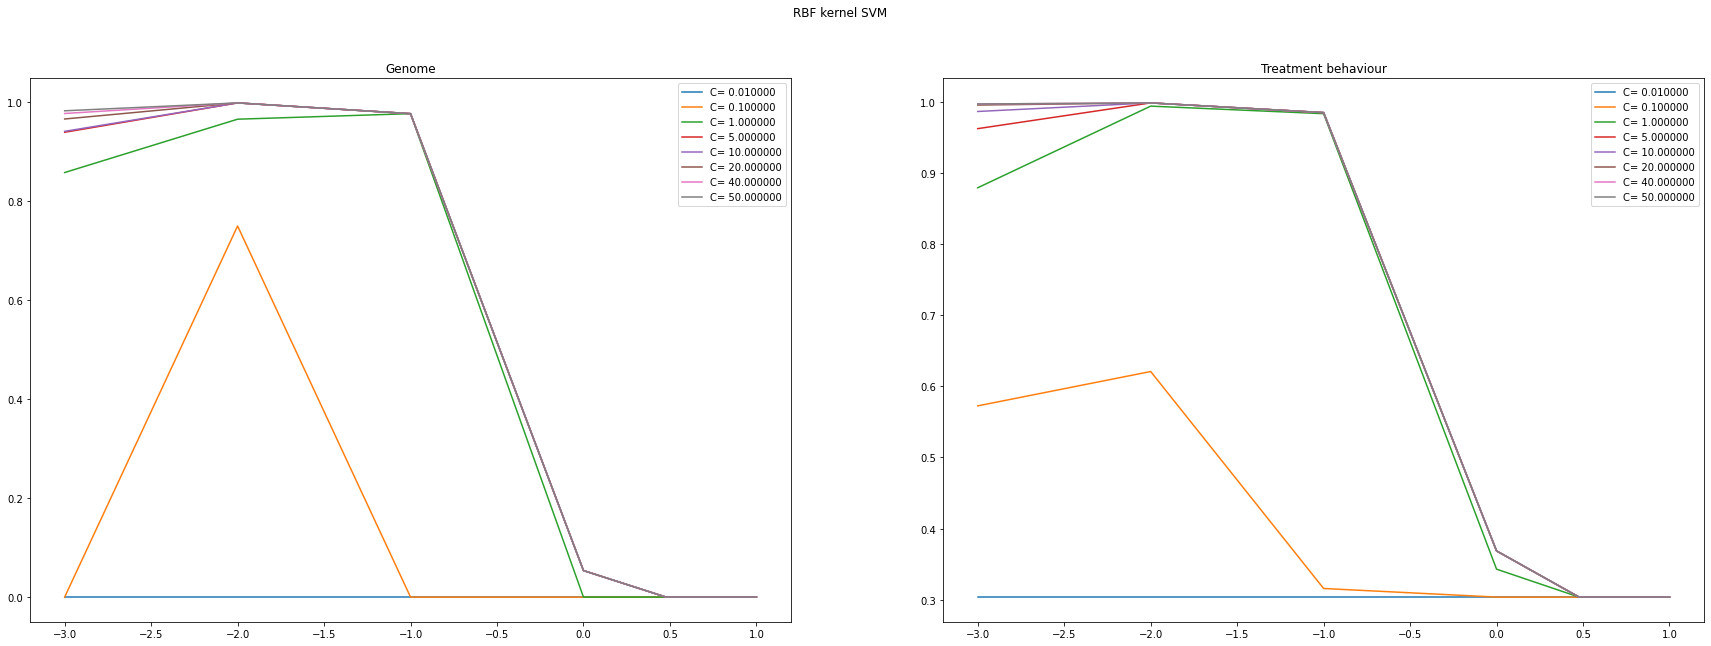

In [ ]:
plt.figure(figsize=(30,10))
ax1 = plt.subplot(122)
for j in clist:
  ax1.plot(np.log10(gamlist),svm_rbf_y2[j],label='C= %f'%j)

plt.legend() 
plt.title('Treatment behaviour')

ax2 = plt.subplot(121)
for j in svm_rbf_y1:
  ax2.plot(np.log10(gamlist),svm_rbf_y1[j],label='C= %f'%j)
plt.title('Genome')

plt.legend()
plt.suptitle('RBF kernel SVM')

plt.show()


For the genome classification, best gamma value is clearly 0.01. Values between C=5 and C=50 give almost same scores, hence we should choose C=5 since it offers more regularisation.

for treatment behaviour classifier, best parameter values are gamma=0.001 and C = 10.

For genome classification:

In [ ]:
svc1 = SVC(C=5, gamma=0.01)
svc1.fit(X1,Y1)
print('Accuracy:',svc1.score(X1val,Y1val))
print('F1-score:',f1_score(Y1val,svc1.predict(X1val)))
print('roc auc score:',roc_auc_score(Y1val,svc1.predict(X1val)))

Accuracy: 1.0
F1-score: 1.0
roc auc score: 1.0


For treatment behaviour classification:

In [ ]:
svc2 = SVC(C=10, gamma=0.001)
svc2.fit(X1,Y2)
print('Accuracy:',svc2.score(X1val,Y2val))
print('F1-score:',f1_score(Y2val,svc2.predict(X1val),average='weighted'))


Accuracy: 1.0
F1-score: 1.0


We got perfect accuracy in both tasks, hence our chosen model is suitable.

### SVM polynomial

In [ ]:
svm_poly_y1 ={}
for C in clist:
  svm_poly_y1[C]=[]
  for gamma in gamlist:
    cvs = cross_val_score(SVC(C=C,gamma=gamma,kernel='poly',coef0=2),X1,Y1,cv=5,scoring='f1')
    svm_poly_y1[C].append(cvs.mean())

In [ ]:
svm_poly_y2 ={}
for C in clist:
  svm_poly_y2[C]=[]
  for gamma in gamlist:
    cvs = cross_val_score(SVC(C=C,gamma=gamma,kernel='poly',coef0=2),X1,Y2,cv=5,scoring=make_scorer(f1_score, average='micro'))
    svm_poly_y2[C].append(cvs.mean())

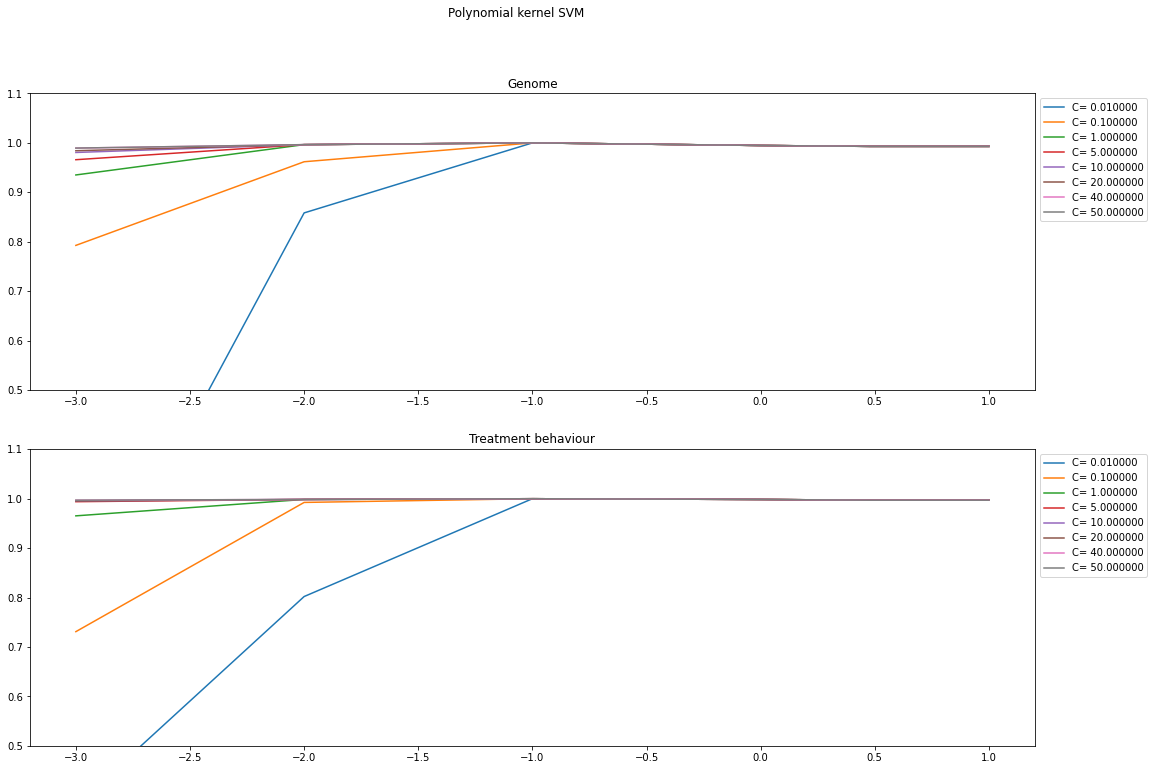

In [ ]:

fig,ax = plt.subplots(2,1,figsize=(18,12))

for j in clist:
  ax[1].plot(np.log10(gamlist),svm_poly_y2[j],label='C= %f'%j)

ax[1].set_ylim([0.5,1.1])
ax[1].set_title('Treatment behaviour')
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

for j in clist:
  ax[0].plot(np.log10(gamlist),svm_poly_y1[j],label='C= %f'%j)
ax[0].set_title('Genome')
ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax[0].set_ylim([0.5,1.1])

plt.suptitle('Polynomial kernel SVM')

plt.show()


For genome classification, gamma=0.1 is appropriate. C=1 seems to be the best option as it has same score as higher C values but provides more regularisation.

For treatment behaviour classification,the best gamma value is 0.01. The model seems to be insensitive to C values greater than 0.1.We see that C = 0.1 gives as much accuracy as higher C values but provides more regularisation. Hence we can consider C=0.1 to be best.

We should choose lowest of the suitable gamma values since this means less support vectors and less overfitting

For the coef0 parameter, we can check for a few values keeping these optimal values C and gamma constant

For genome classification:

In [ ]:
svc21 = SVC(C=1, gamma=0.01,kernel='poly',coef0=1)
svc21.fit(X1,Y1)
print('Accuracy:',svc21.score(X1val,Y1val))
print('F1-score:',f1_score(Y1val,svc21.predict(X1val)))
print('roc auc score:',roc_auc_score(Y1val,svc21.predict(X1val)))

Accuracy: 1.0
F1-score: 1.0
roc auc score: 1.0


For treatment behaviour classification

In [ ]:
svc22 = SVC(C=0.1, gamma=0.01,kernel='poly',coef0=2)
svc22.fit(X1,Y2)
print('Accuracy:',svc22.score(X1val,Y2val))
print('F1-score:',f1_score(Y2val,svc22.predict(X1val),average='micro'))


Accuracy: 1.0
F1-score: 1.0


We got near perfect accuracy on both classification tasks, using the chosen parameters, hence the model is quite suitable

### Random Forest

Since there are more than 2 hyperparameters to be tuned, it is easier to use grid search CV to find the best combination of hyperparameters. We can use F1-score metric in both classification tasks with appropriate averaging method.

N.B Default folds in gridsearch CV is 5, hence we need not explicitly pass the argument

The number of rows in the dataset is not very large (662), hence we do not need too many trees. We can test in the range 60-120, and we should also keep min samples split small, for this reason.

The number of features are quite large hence we should control max features.
the default is sqrt which turns out to be 0.8 in this case, so we should try for fewer features, but sufficient. hence we can try in the range 0.5-1.

The range 4-7  is a good choice for tree depth, since larger values would lead to overfitting, ad smaller ones lead to underfitting.

Genome classification

In [ ]:
params = {'n_estimators':[60,80,100,120],'max_depth':[4,5,6,7],'max_features':[0.6,0.7,0.8,1],'min_samples_split':[8,10,12]}

grid = GridSearchCV(RandomForestClassifier(),param_grid=params,scoring='f1')
grid.fit(X1,Y1)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': [0.6, 0.7, 0.8, 1],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [60, 80, 100, 120]},
             scoring='f1')

In [ ]:

grid.best_params_

{'max_depth': 7,
 'max_features': 0.6,
 'min_samples_split': 10,
 'n_estimators': 60}

In [ ]:
rf1 = RandomForestClassifier(n_estimators = 80,max_depth = 7,min_samples_split=10,max_features=0.6,random_state=1)
rf1.fit(X1,Y1)

RandomForestClassifier(max_depth=7, max_features=0.6, min_samples_split=10,
                       n_estimators=80, random_state=1)

In [ ]:
print('Accuracy:',rf1.score(X1val,Y1val))
print('F1-score:',f1_score(Y1val,rf1.predict(X1val)))
print('Roc_auc_score:',roc_auc_score(Y1val,rf1.predict(X1val)))

Accuracy: 0.91
F1-score: 0.8831168831168832
Roc_auc_score: 0.8961412151067323


Treatment behavious classification:

In [ ]:
grid2 = GridSearchCV(RandomForestClassifier(),param_grid=params,scoring=make_scorer(f1_score, average='micro'))
grid2.fit(X1,Y2)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': [0.6, 0.7, 0.8, 1],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [60, 80, 100, 120]},
             scoring=make_scorer(f1_score, average=micro))

In [ ]:
grid2.best_params_

{'max_depth': 7,
 'max_features': 0.6,
 'min_samples_split': 8,
 'n_estimators': 100}

In [ ]:
rf2 = RandomForestClassifier(max_depth=7,max_features=0.6,min_samples_split=8,n_estimators=80,random_state=1)
rf2.fit(X1,Y2)

RandomForestClassifier(max_depth=7, max_features=0.6, min_samples_split=8,
                       n_estimators=80, random_state=1)

In [ ]:
print('Accuracy:',rf2.score(X1val,Y2val))
print('F1-score:',f1_score(Y2val,rf2.predict(X1val),average='micro'))


Accuracy: 0.97
F1-score: 0.97


We got good accuracy in both classification tasks , but not as good as SVM classfier

### Elastic Net Logistic Regression

Genome Classification

We take evenly spaced 10 values between 0 and 1 as the ratio of l1 and l2 in elastic net.

In [ ]:
params_lr = {'l1_ratio':np.linspace(0.0 ,1.0 ,10)} #defining parameters to be used in gridsearch

grid_lr = GridSearchCV(LogisticRegression(penalty = 'elasticnet', random_state = 0, solver = 'saga', max_iter = 1e5), param_grid=params_lr, scoring='f1', cv = 5) #declaring a grid search variable with all required parameters
grid_lr.fit(X1,Y1) #fitting over the training dataset

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=100000.0,
                                          penalty='elasticnet', random_state=0,
                                          solver='saga'),
             param_grid={'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             scoring='f1')

In [ ]:
grid_lr.best_params_ #looking at best parameter values

{'l1_ratio': 0.2222222222222222}

In [ ]:
lr_1 = LogisticRegression(C = 100, penalty = 'elasticnet', random_state = 0, max_iter = 1e5, solver = 'saga', l1_ratio = 0.2, warm_start = True, fit_intercept = True) #putting best parameter values and definining the logistic regression model with elastic net penalty

In [ ]:
lr_1.fit(X1,Y1) #fitting the training data with the created model

LogisticRegression(C=100, l1_ratio=0.2, max_iter=100000.0, penalty='elasticnet',
                   random_state=0, solver='saga', warm_start=True)

In [ ]:
print('Accuracy:',lr_1.score(X1val,Y1val)) #finding the accuracy over the validation data
print('F1-score:',f1_score(Y1val,lr_1.predict(X1val))) #finding the f1 score over the validation data
print('Roc_auc_score:',roc_auc_score(Y1val,lr_1.predict(X1val))) #finding the roc_auc_score over the validation data

Accuracy: 0.97
F1-score: 0.962962962962963
Roc_auc_score: 0.9642857142857143


We get pretty good metric results for the binary target variable.

Treatment Behavior Classification

In [ ]:
params_lr = {'l1_ratio':np.linspace(0.0 ,1.0 ,10)} #defining parameters to be used in gridsearch

grid_lr_2 = GridSearchCV(LogisticRegression(penalty = 'elasticnet', random_state = 0, solver = 'saga', max_iter = 1e5),param_grid=params_lr,scoring=make_scorer(f1_score, average='micro')) #declaring a grid search variable with all required parameters

grid_lr_2.fit(X1, Y2) #fitting over the train dataset

GridSearchCV(estimator=LogisticRegression(max_iter=100000.0,
                                          penalty='elasticnet', random_state=0,
                                          solver='saga'),
             param_grid={'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             scoring=make_scorer(f1_score, average=micro))

In [ ]:
grid_lr_2.best_params_ #looking at the best parameter value

{'l1_ratio': 0.0}

In [ ]:
lr_2 = LogisticRegression(C = 100, penalty = 'elasticnet', random_state = 0, max_iter = 1e5, solver = 'saga', l1_ratio = 0.0, warm_start = True, fit_intercept = True) #defining our logistic model with the best parameter values achieved earlier

In [ ]:
lr_2.fit(X1, Y2) #fitting the training dataset with the created model

LogisticRegression(C=100, l1_ratio=0.0, max_iter=100000.0, penalty='elasticnet',
                   random_state=0, solver='saga', warm_start=True)

In [ ]:
print('Accuracy:',lr_2.score(X1val,Y2val)) #finding accuracy over the validation data
print('F1-score:',f1_score(Y2val,lr_2.predict(X1val), average='micro')) #finding f1 score over the validation data

Accuracy: 0.98
F1-score: 0.98


We get pretty good scores in multi class classification as well. Though, we planned to use elastic net but on running grid search, the best l1 ration computed is 0 which essentially makes the penalty 'l2'

When using Logistic Regression, we get very good accuracy and f1 score, better than Random Forest. 

###Neural Network

We are supposed to use a single hidden layer with Relu activation function, as for the no. of neurons, we take values from 4 to 10, since having too many neurons could result in overfitting. 
As for weight decay, we take values between 0.0001 to 0.1.

Genome Classification

In [ ]:
params_nn = {'hidden_layer_sizes':[(4,),(6,),(8,),(10,)], 'alpha':[0.0001, 0.001, 0.01, 0.1]} #defning parameter to be used in grid search

grid_nn = GridSearchCV(MLPClassifier(activation = 'relu', solver = 'adam', max_iter = 1000), param_grid=params_nn, scoring='f1', cv = 5) #declaring a grid search variable with all required parameters
grid_nn.fit(X1,Y1) #fitting over the training dataset

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(4,), (6,), (8,), (10,)]},
             scoring='f1')

In [ ]:
grid_nn.best_params_ #looking at the best parameter values

{'alpha': 0.0001, 'hidden_layer_sizes': (10,)}

In [ ]:
nn = MLPClassifier(activation = 'relu', solver = 'adam', max_iter = 1000, alpha = 0.0001, hidden_layer_sizes = (4,)) #declaring the model with the best parameter values achieved earlier
nn.fit(X1, Y1) #fitting the training dataset with the created model

MLPClassifier(hidden_layer_sizes=(4,), max_iter=1000)

In [ ]:
print('Accuracy:',nn.score(X1val,Y1val)) #finding accuracy over the validation dataset
print('F1-score:',f1_score(Y1val,nn.predict(X1val))) #finding f1 score over the validation dataset
print('Roc_auc_score:',roc_auc_score(Y1val,nn.predict(X1val))) #finding roc auc score over the validation dataset

Accuracy: 1.0
F1-score: 1.0
Roc_auc_score: 1.0


In [ ]:
nn.out_activation_

'logistic'

The output activation function is logistic function which is essentially the softmax function in the binary case.


Treatment Behaviour Classification

In [ ]:
grid_nn_2 = GridSearchCV(MLPClassifier(activation = 'relu', solver = 'adam', max_iter = 1000), param_grid=params_nn, scoring=make_scorer(f1_score, average='micro'), cv = 5) #we use the same parameter values and define a grid search variable with all parameter required
grid_nn_2.fit(X1,Y2) #fitting over the training dataset

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(4,), (6,), (8,), (10,)]},
             scoring=make_scorer(f1_score, average=micro))

In [ ]:
grid_nn_2.best_params_ #looking at best parameter values

{'alpha': 0.0001, 'hidden_layer_sizes': (10,)}

In [ ]:
nn_2 = MLPClassifier(activation = 'relu', solver = 'adam', max_iter = 1000, alpha = 0.0001, hidden_layer_sizes = (10,)) #declaring a neural network model with best parameter values achieved earlier
nn_2.fit(X1, Y2) #fitting over the training dataset

MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)

In [ ]:
print('Accuracy:',nn_2.score(X1val,Y2val)) #finding the accuracy over the validation data
print('F1-score:',f1_score(Y2val,nn_2.predict(X1val), average='micro')) #finding the f1 score over the validation data

Accuracy: 1.0
F1-score: 1.0


In [ ]:
nn_2.out_activation_

'softmax'

We can see that the output activation function is softmax.

We get perfect accuracy and F1 score in both Genome and Treatment Behaviour Classification when using Neural Networks.

###Feature importance


SVC RBF 

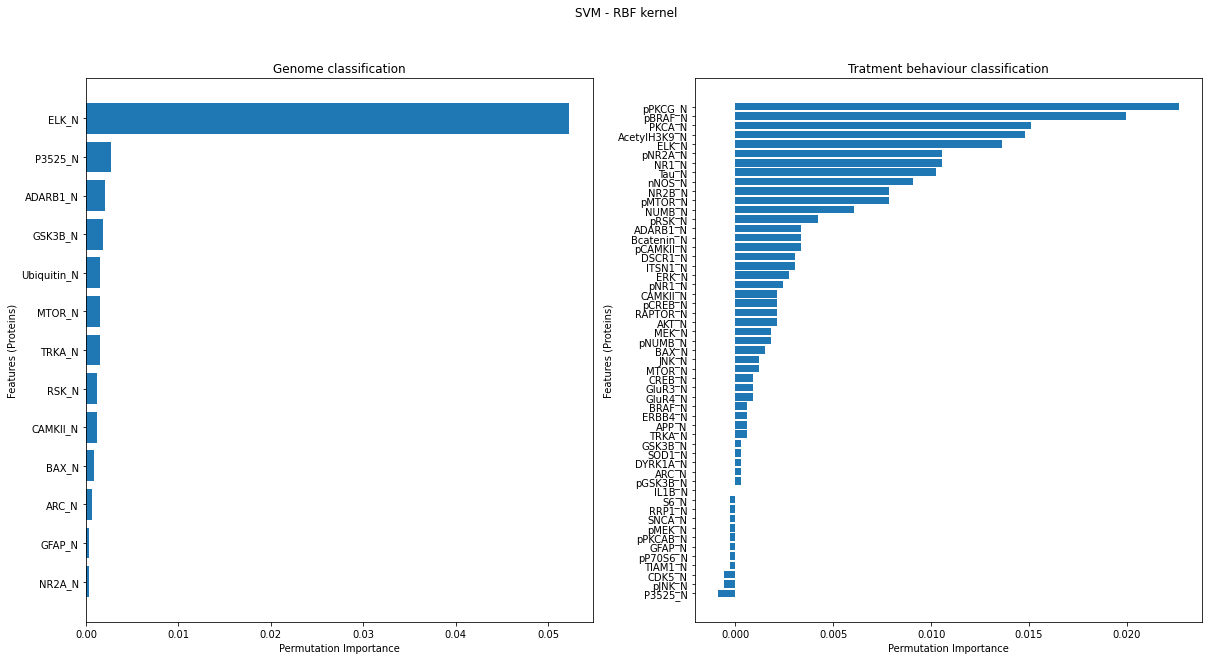

In [ ]:
plt.figure(figsize = (20,10)) #setting plot size
ax1=plt.subplot(121) #first subplot
svc1_fi = permutation_importance(svc1, X1, Y1, random_state = 0) #running permutation importance on the training set and storing the matrix
idx = svc1_fi.importances_mean.argsort() #getting the indices in decreasing order of the importance mean score
idx = np.setdiff1d(idx, np.where(abs(svc1_fi.importances_mean) == 0), assume_unique = True) #getting the indices with nonzero score
a = X.columns[idx] #storing the columns with non zero importance score
plt.barh(X.columns[idx], svc1_fi.importances_mean[idx]) #plotting a horizontal bar chart of column names against importance score
plt.xlabel('Permutation Importance') #labelling x axis
plt.ylabel('Features (Proteins)') #labelling y axis
plt.title('Genome classification') #labelling the plot
ax2 = plt.subplot(122) #second subplot
svc2_fi = permutation_importance(svc2, X1, Y2, random_state = 0) #running permutation importance on the training set and storing the matrix
idx = svc2_fi.importances_mean.argsort() #getting the indices in decreasing order of the importance mean score
idx = np.setdiff1d(idx, np.where(abs(svc2_fi.importances_mean) == 0), assume_unique = True) #getting the indices with nonzero score
b = X.columns[idx] #storing the columns with non zero importance score
plt.barh(X.columns[idx], svc2_fi.importances_mean[idx]) #plotting a horizontal bar chart of column names against importance score
plt.xlabel('Permutation Importance') #labelling x axis
plt.ylabel('Features (Proteins)') #labelling y axis
plt.title('Tratment behaviour classification') #labelling the plot
plt.suptitle('SVM - RBF kernel') #labelling the figure
plt.show()

SVC Polynomial

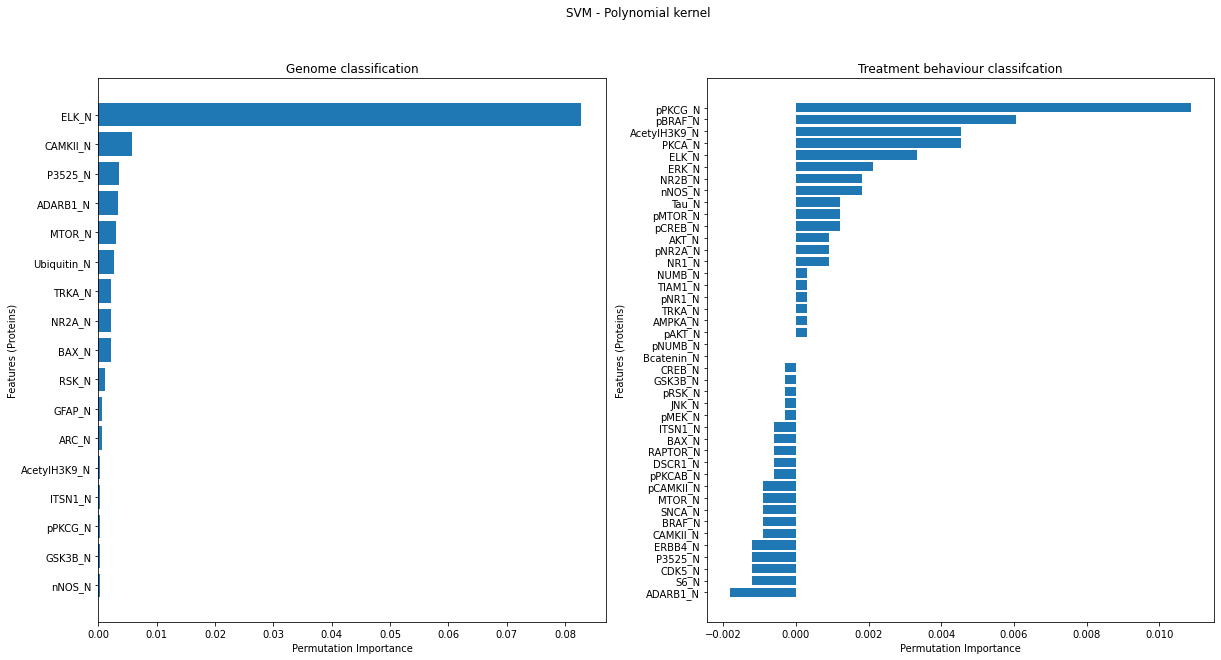

In [ ]:
plt.figure(figsize = (20,10)) #setting plot size
ax1=plt.subplot(121) #first subplot
svc21_fi = permutation_importance(svc21, X1, Y1, random_state = 0) #running permutation importance on the training set and storing the matrix
idx = svc21_fi.importances_mean.argsort() #getting the indices in decreasing order of the importance mean score
idx = np.setdiff1d(idx, np.where(abs(svc21_fi.importances_mean) == 0), assume_unique = True) #getting the indices with nonzero score
c = X.columns[idx] #storing the columns with non zero importance score
ax1.barh(X.columns[idx], svc21_fi.importances_mean[idx])#plotting a horizontal bar chart of column names against importance score
plt.xlabel('Permutation Importance') #labelling x axis
plt.ylabel('Features (Proteins)') #labelling y axis
plt.title('Genome classification') #labelling the plot

ax2=plt.subplot(122)#second subplot
svc22_fi = permutation_importance(svc22, X1, Y2, random_state = 0)#running permutation importance on the training set and storing the matrix
idx = svc22_fi.importances_mean.argsort() #getting the indices in decreasing order of the importance mean score
idx = np.setdiff1d(idx, np.where(abs(svc22_fi.importances_mean) == 0), assume_unique = True) #getting the indices with nonzero score
d = X.columns[idx] #storing the columns with non zero importance score
ax2.barh(X.columns[idx], svc22_fi.importances_mean[idx]) #plotting a horizontal bar chart of column names against importance score
plt.xlabel('Permutation Importance') #labelling x axis
plt.ylabel('Features (Proteins)') #labelling y axis
plt.title('Treatment behaviour classifcation') #labelling the plot
plt.suptitle('SVM - Polynomial kernel') #labelling the figure
plt.show()

Random Forest

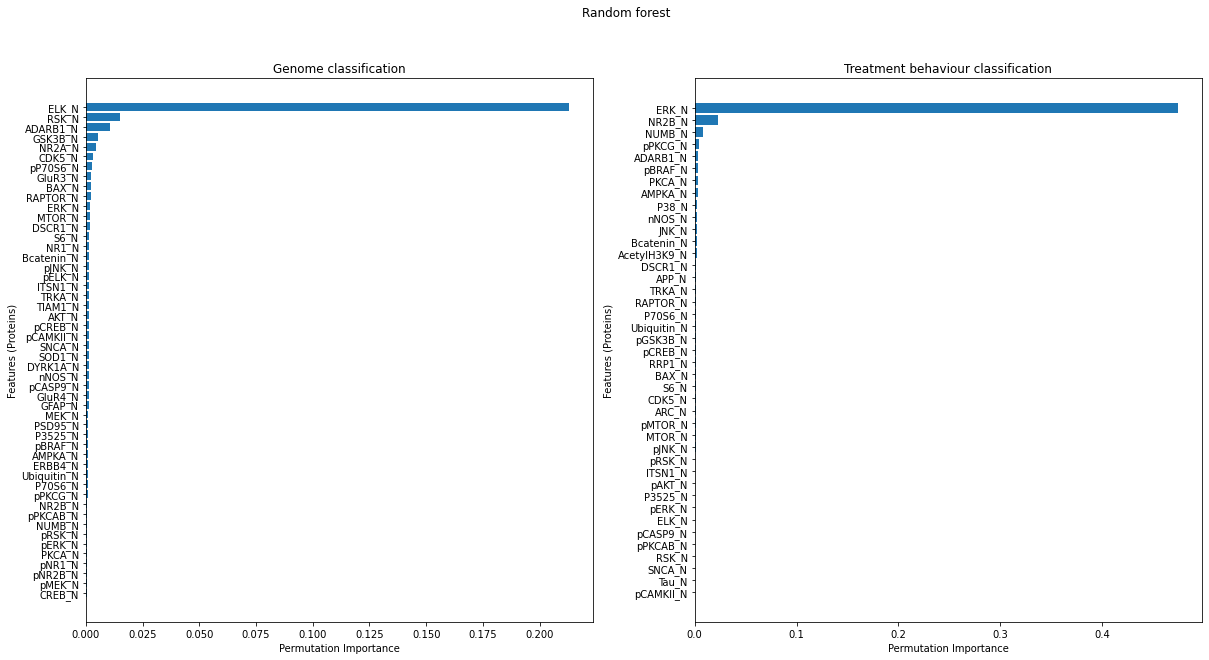

In [ ]:
plt.figure(figsize = (20,10)) #setting plot size
ax1=plt.subplot(121) #first subplot
rf1_fi = permutation_importance(rf1, X1, Y1, random_state = 0) #running permutation importance on the training set and storing the matrix
idx = rf1_fi.importances_mean.argsort() #getting the indices in decreasing order of the importance mean score
idx = np.setdiff1d(idx, np.where(abs(rf1_fi.importances_mean) == 0), assume_unique = True) #getting the indices with nonzero score
e = X.columns[idx]#storing the columns with non zero importance score
ax1.barh(X.columns[idx], rf1_fi.importances_mean[idx]) #plotting a horizontal bar chart of column names against importance score
plt.xlabel('Permutation Importance') #labelling x axis
plt.ylabel('Features (Proteins)') #labelling y axis
plt.title('Genome classification') #labelling the plot

ax2=plt.subplot(122) #second subplot
rf2_fi = permutation_importance(rf2, X1, Y2, random_state = 0) #running permutation importance on the training set and storing the matrix
idx = rf2_fi.importances_mean.argsort() #getting the indices in decreasing order of the importance mean score
idx = np.setdiff1d(idx, np.where(abs(rf2_fi.importances_mean) == 0), assume_unique = True) #getting the indices with nonzero score
f = X.columns[idx] #storing the columns with non zero importance score
ax2.barh(X.columns[idx], rf2_fi.importances_mean[idx]) #plotting a horizontal bar chart of column names against importance score
plt.xlabel('Permutation Importance') #labelling x axis
plt.ylabel('Features (Proteins)') #labelling y axis

plt.title('Treatment behaviour classification')
 #labelling the plot
plt.suptitle('Random forest')
 #labelling the figure
plt.show()

Logistic Regression

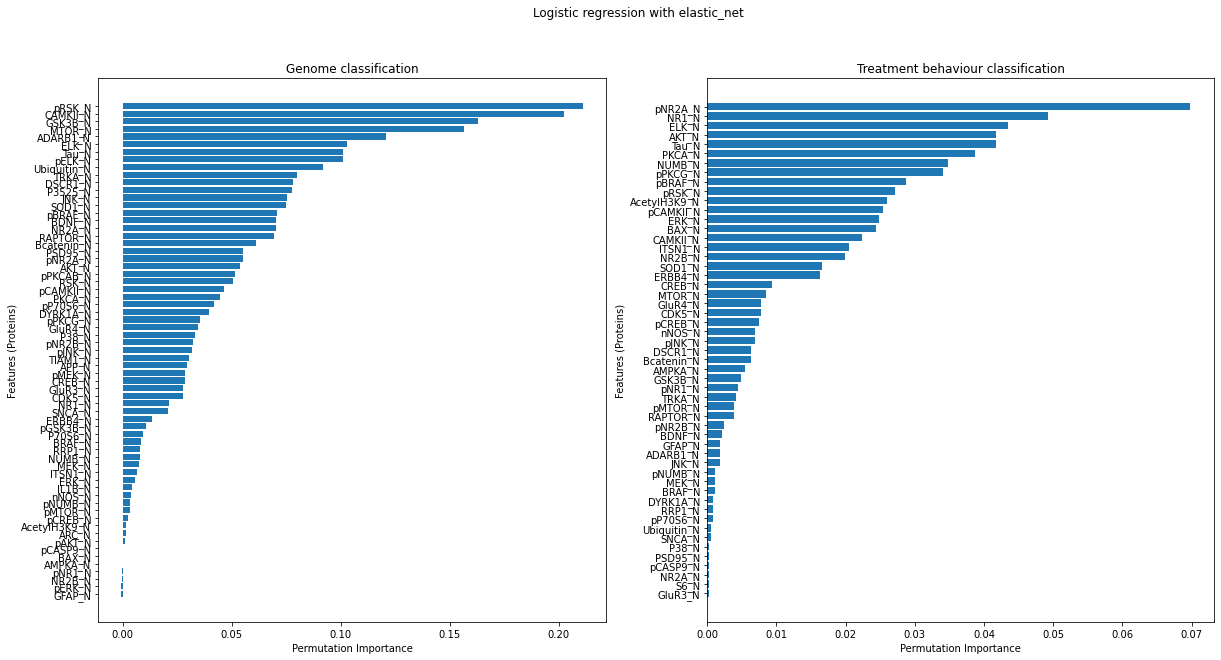

In [ ]:
plt.figure(figsize = (20,10)) #setting plot size
ax1=plt.subplot(121) #first subplot
lr1_fi = permutation_importance(lr_1, X1, Y1, random_state = 0) #running permutation importance on the training set and storing the matrix
idx = lr1_fi.importances_mean.argsort() #getting the indices in decreasing order of the importance mean score
idx = np.setdiff1d(idx, np.where(abs(lr1_fi.importances_mean) == 0), assume_unique = True) #getting the indices with nonzero score
g = X.columns[idx] #storing the columns with non zero importance score
plt.barh(X.columns[idx], lr1_fi.importances_mean[idx]) #plotting a horizontal bar chart of column names against importance score
plt.xlabel('Permutation Importance') #labelling x axis
plt.ylabel('Features (Proteins)') #labelling y axis
plt.title('Genome classification') #labelling the plot

ax2=plt.subplot(122) #second subplot
lr2_fi = permutation_importance(lr_2, X1, Y2, random_state = 0) #running permutation importance on the training set and storing the matrix
idx = lr2_fi.importances_mean.argsort() #getting the indices in decreasing order of the importance mean score
idx = np.setdiff1d(idx, np.where(abs(lr2_fi.importances_mean) == 0), assume_unique = True) #getting the indices with nonzero score
h = X.columns[idx] #storing the columns with non zero importance score
plt.barh(X.columns[idx], lr2_fi.importances_mean[idx]) #plotting a horizontal bar chart of column names against importance score
plt.xlabel('Permutation Importance') #labelling x axis
plt.ylabel('Features (Proteins)') #labelling y axis
plt.title('Treatment behaviour classification') #labelling the plot
plt.suptitle('Logistic regression with elastic_net') #labelling the figure

plt.show()

Neural Network 

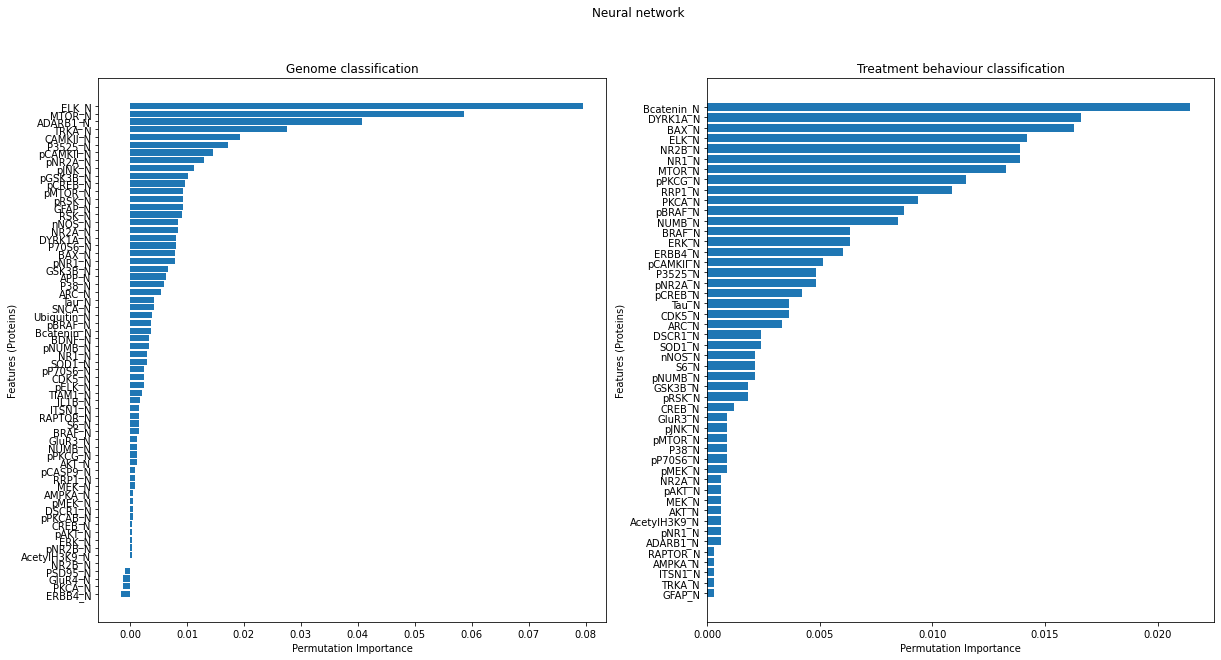

In [ ]:
plt.figure(figsize = (20,10)) #setting plot size
ax1=plt.subplot(121) #first subplot
nn1_fi = permutation_importance(nn, X1, Y1, random_state = 0) #running permutation importance on the training set and storing the matrix
idx = nn1_fi.importances_mean.argsort() #getting the indices in decreasing order of the importance mean score
idx = np.setdiff1d(idx, np.where(abs(nn1_fi.importances_mean) == 0), assume_unique = True) #getting the indices with nonzero score
i = X.columns[idx] #storing the columns with non zero importance score
plt.barh(X.columns[idx], nn1_fi.importances_mean[idx]) #plotting a horizontal bar chart of column names against importance score
plt.xlabel('Permutation Importance') #labelling x axis
plt.ylabel('Features (Proteins)') #labelling y axis
plt.title('Genome classification') #labelling the plot

ax2=plt.subplot(122) #second subplot
nn2_fi = permutation_importance(nn_2, X1, Y2, random_state = 0) #running permutation importance on the training set and storing the matrix
idx = nn2_fi.importances_mean.argsort() #getting the indices in decreasing order of the importance mean score
idx = np.setdiff1d(idx, np.where(abs(nn2_fi.importances_mean) == 0), assume_unique = True) #getting the indices with nonzero score
j = X.columns[idx] #storing the columns with non zero importance score
plt.barh(X.columns[idx], nn2_fi.importances_mean[idx]) #plotting a horizontal bar chart of column names against importance score
plt.xlabel('Permutation Importance') #labelling x axis
plt.ylabel('Features (Proteins)') #labelling y axis
plt.title('Treatment behaviour classification') #labelling the plot
plt.suptitle('Neural network') #labelling the figure

plt.show()

In [ ]:
np.intersect1d(np.intersect1d(np.intersect1d(a,c),np.intersect1d(e,g)),i) #getting the features which have importance score non zero in all models for genome classification

array(['ADARB1_N', 'BAX_N', 'ELK_N', 'GFAP_N', 'GSK3B_N', 'MTOR_N',
       'NR2A_N', 'P3525_N', 'RSK_N', 'TRKA_N', 'Ubiquitin_N'],
      dtype=object)

In [ ]:
np.intersect1d(np.intersect1d(np.intersect1d(b,d),np.intersect1d(f,h)),j) #getting the features which have importance score non zero in all models for treatment behaviour classification

array(['ADARB1_N', 'AcetylH3K9_N', 'BAX_N', 'Bcatenin_N', 'CDK5_N',
       'DSCR1_N', 'ELK_N', 'ERK_N', 'ITSN1_N', 'JNK_N', 'MTOR_N',
       'NR2B_N', 'NUMB_N', 'PKCA_N', 'RAPTOR_N', 'S6_N', 'SNCA_N',
       'TRKA_N', 'Tau_N', 'nNOS_N', 'pBRAF_N', 'pCAMKII_N', 'pCREB_N',
       'pMTOR_N', 'pPKCG_N', 'pRSK_N'], dtype=object)

For Genome Classification Models,

'ADARB1_N', 'BAX_N', 'ELK_N', 'GFAP_N', 'GSK3B_N', 'MTOR_N',
       'NR2A_N', 'P3525_N', 'RSK_N', 'TRKA_N', 'Ubiquitin_N' are the proteins which are important in all the models.

For Treatment Behaviour Classification Models,

'ADARB1_N', 'AcetylH3K9_N', 'BAX_N', 'Bcatenin_N', 'CDK5_N',
       'DSCR1_N', 'ELK_N', 'ERK_N', 'ITSN1_N', 'JNK_N', 'MTOR_N',
       'NR2B_N', 'NUMB_N', 'PKCA_N', 'RAPTOR_N', 'S6_N', 'SNCA_N',
       'TRKA_N', 'Tau_N', 'nNOS_N', 'pBRAF_N', 'pCAMKII_N', 'pCREB_N',
       'pMTOR_N', 'pPKCG_N', 'pRSK_N' are the proteins which are important in all the models.

We can try to fit a model with only important features and see the result


In [ ]:
mask=svc1_fi.importances_mean>0 #storing all feature indices with importance score more than 0
p = list(mask) #converting to a list

In [ ]:
svc11 = SVC(C=5,gamma=0.1) #making a svc model with calculated parameters
svc11.fit(X1.iloc[:,p],Y1) #fitting with the created model over the dataset with selected features

SVC(C=5, gamma=0.1)

In [ ]:
Xsval = X1val.iloc[:,p] #creating validation dataset with selected features
print('Accuracy:',svc11.score(Xsval,Y1val)) #finding accuracy
print('F1-score:',f1_score(Y1val,svc11.predict(Xsval))) #finding f1 score
print('roc auc score:',roc_auc_score(Y1val,svc11.predict(Xsval)))#finding roc auc score

Accuracy: 0.98
F1-score: 0.9767441860465117
roc auc score: 0.9827586206896552


We see that if only go by the feature importance while selecting features, then we get a lower validation accuracy, but it is still decently good hence we can depend on this method to reduce dimensionality if needed. However we need to train the model on whole data to get feature importances so it is computationaly slightly more expensive

### Recursive Feature Elimination

In [ ]:
rf1_feat = RFECV(rf1,step=1) #creating recursive feature elimination for random forest
rf1_feat.fit(X1,Y1) #fitting over training dataset

RFECV(estimator=RandomForestClassifier(max_depth=7, max_features=0.6,
                                       min_samples_split=10, n_estimators=80,
                                       random_state=1))

In [ ]:
X1newrf = rf1_feat.transform(X1) #creating new training dataframe with just the calculated important features
X1valnewrf = rf1_feat.transform(X1val) #creating new validation dataframe with just the calculated important features

In [ ]:
rf1new = RandomForestClassifier(max_depth=7, max_features=0.6,
                                       min_samples_split=10, n_estimators=80,
                                       random_state=1) #creating random forest model with pre calculated parameters
rf1new.fit(X1newrf,Y1) #fitting over the new training dataset

RandomForestClassifier(max_depth=7, max_features=0.6, min_samples_split=10,
                       n_estimators=80, random_state=1)

In [ ]:
print('Accuracy:',rf1new.score(X1valnewrf,Y1val)) #finding validation accuracy
print('F1-score:',f1_score(Y1val,rf1new.predict(X1valnewrf))) #finding validation f1 score
print('Roc_auc_score:',roc_auc_score(Y1val,rf1new.predict(X1valnewrf))) #finding roc auc score over validation data

Accuracy: 0.9
F1-score: 0.8717948717948718
Roc_auc_score: 0.88752052545156


We see that even after reducing the amount of features used from 66 to 24 using RFECV, we still get almost same validation accuracy,at reduced computation cost


In [ ]:
lr1_rfecv=RFECV(lr_1) #creating recursive feature elimination for linear regression
lr1_rfecv.fit(X1, Y1) #fitting over training dataset

RFECV(estimator=LogisticRegression(C=100, l1_ratio=0.2, max_iter=100000.0,
                                   penalty='elasticnet', random_state=0,
                                   solver='saga', warm_start=True))

In [ ]:
X1lrN = lr1_rfecv.transform(X1) #creating new training dataframe with just the calculated important features
X1lrN_val = lr1_rfecv.transform(X1val) #creating new test dataframe with just the calculated important features

In [ ]:
lr1_ = LogisticRegression(C=100, l1_ratio=0.2, max_iter=100000.0,penalty='elasticnet', random_state=0,solver='saga', warm_start=True, fit_intercept = True) #creating new logistic regression model
lr1_.fit(X1lrN, Y1) #fitting over newly created training dataframe

LogisticRegression(C=100, l1_ratio=0.2, max_iter=100000.0, penalty='elasticnet',
                   random_state=0, solver='saga', warm_start=True)

In [ ]:
print('Accuracy:',lr1_.score(X1lrN_val,Y1val)) #finding validation accuracy
print('F1-score:',f1_score(Y1val,lr1_.predict(X1lrN_val))) #finding validation f1 score 
print('Roc_auc_score:',roc_auc_score(Y1val,lr1_.predict(X1lrN_val))) #finding roc auc score over validation data

Accuracy: 0.95
F1-score: 0.9367088607594937
Roc_auc_score: 0.9404761904761905


For Logistic Regression, features are reduced from 66 to 49, which is a significant decrease but we do not see a major fall in the accuracy.

Since all features have non importance score for neural network, we will not perform feature elimination for it.

### Using good models on test data.

For Genome classification, the SVMs and the neural network gave perfect validation accuracy.

In [ ]:
print('Support vector classifier with RBF kernel')
print('Accuracy:',svc1.score(X1test,Y1test))
print('F1-score:',f1_score(Y1test,svc1.predict(X1test)))
print('roc auc score:',roc_auc_score(Y1test,svc1.predict(X1test)),'\n\n')

print('Support vector classifier with polynomial kernel')
print('Accuracy:',svc21.score(X1test,Y1test))
print('F1-score:',f1_score(Y1test,svc21.predict(X1test)))
print('roc auc score:',roc_auc_score(Y1test,svc21.predict(X1test)),'\n\n')

print('Neural Network')
print('Accuracy:',nn.score(X1test,Y1test))
print('F1-score:',f1_score(Y1test,nn.predict(X1test)))
print('roc auc score:',roc_auc_score(Y1test,nn.predict(X1test)))

Support vector classifier with RBF kernel
Accuracy: 0.8577777777777778
F1-score: 0.8139534883720929
roc auc score: 0.8444444444444443 


Support vector classifier with polynomial kernel
Accuracy: 0.8622222222222222
F1-score: 0.8248587570621468
roc auc score: 0.8537037037037036 


Neural Network
Accuracy: 0.7911111111111111
F1-score: 0.768472906403941
roc auc score: 0.8037037037037037


For Treatment behvaiour classification, the SVMs and the neural network gave perfect validation accuracy

In [ ]:
print('Support vector classifier with RBF kernel')
print('Accuracy:',svc2.score(X1test,Y2test))
print('F1-score:',f1_score(Y2test,svc2.predict(X1test),average='micro'),'\n\n')

print('Support vector classifier with polynomial kernel')
print('Accuracy:',svc22.score(X1test,Y2test))
print('F1-score:',f1_score(Y2test,svc22.predict(X1test),average='micro'),'\n\n')

print('Neural Network')
print('Accuracy:',nn_2.score(X1test,Y2test))
print('F1-score:',f1_score(Y2test,nn_2.predict(X1test),average='micro'))


Support vector classifier with RBF kernel
Accuracy: 0.88
F1-score: 0.88 


Support vector classifier with polynomial kernel
Accuracy: 0.8977777777777778
F1-score: 0.8977777777777778 


Neural Network
Accuracy: 0.8977777777777778
F1-score: 0.8977777777777778


For SVM we see a relatively poor test accuracy in the classification tasks. The reason could be:\
1) The fraction of values imputed in the test data are higher than in train data ( For one particular attribute 40% of the values were imputed.)\
2) The train and test data are not from the exact same distribution. ( As we see below, for most of the attributes, the mean and variance are not close to 0 and 1 respectively), while the validation set was from the same dataset as the train data.

For the neural network as well, the accuracy is not very good for genome classification, this suggests that the neural net might be overfit to the train dataset (It gave good validation accuracy since they were from same dataset)

Using our strategy of feature selection(eliminating low variance and correlated variables) we got a good performance from our model, hence we need not consider other strategies of feature elimination.

### References

References:

https://stackoverflow.com/questions/37413302/f1-score-of-all-classes-from-scikits-cross-val-score

https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285

https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw